In [2]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import matplotlib.pyplot as plt



In [3]:
Si = mp.Medium(index = 3.4)
SiO2 = mp.Medium(index = 1.44)

In [11]:
resolution = 20

Sx = 6 # 6um
Sy = 5 # 5um

cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(1)]


In [12]:
fcen = 1 / 1.55
width = 0.1
fwidth = width * fcen
source_center = [-1, 0, 0]
source_size = mp.Vector3(0, 2, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

In [13]:
design_region_resolution = 10
Nx = design_region_resolution + 1
Ny = design_region_resolution + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables, volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
)


geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 0.5, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(y=Sy / 4), material=Si, size=mp.Vector3(0.5, Sy / 2, 0)
    ),  # vertical waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
    # mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
    #        e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
    #
    # The commented lines above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; We give an alternative approach to impose symmetry in later tutorials.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]

In [14]:
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

     block, center = (-1.5,0,0)
          size (3,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,1.25,0)
          size (0.5,2.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (1,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

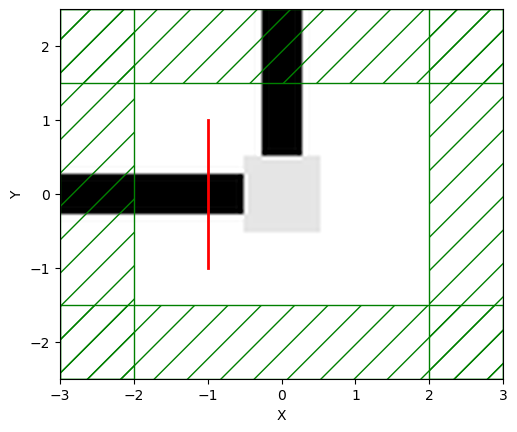

In [15]:
sim.plot2D()

In [16]:
TE0 = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(0, 1, 0), size=mp.Vector3(x=2)), mode=1
)
ob_list = [TE0]

In [18]:
def J(alpha):
    return npa.abs(alpha) ** 2

In [20]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
)

In [21]:
x0 = np.random.rand(Nx * Ny)
opt.update_design([x0])

     block, center = (-1.5,0,0)
          size (3,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,1.25,0)
          size (0.5,2.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (1,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)


/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:533: UserWarning: The frequency parameter of plot2D has been deprecated. Use the frequency key of the eps_parameters dictionary instead.
  warnings.warn(


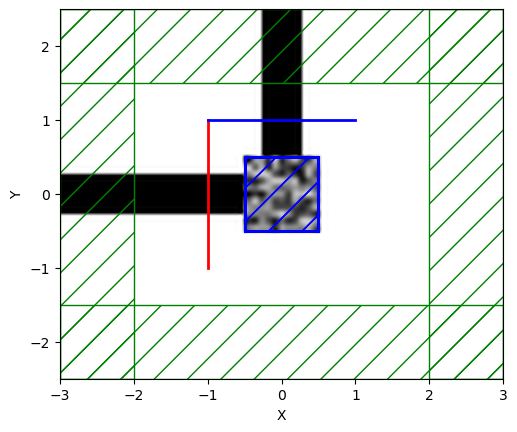

In [22]:
opt.plot2D(True, frequency=1 / 1.55)
plt.show()